<a href="https://colab.research.google.com/github/shumshersubashgautam/Quantum-Reinforcement-Learning/blob/main/DQN_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Quantum Deep Q-Learning: analysis and results:**
In this Notebook you can use the trained quantum agent to analyze its performances and make some nice plots.It cointains essentially the same steps of the other Quantum Deep Q-Learning notebook, but without explaining all the theory and details of the implementation. All the custom functions implementing Elliot (the quantum agent) are present in the script dqn_definitions, which is here imported.In particular, here we show how to use the qasm_simulator to perform some noisy simulation of the quantum neural network circuit, and show how the number of shots impacts the performances of the quantum agent, Elliot.


In [8]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
import qiskit_machine_learning as qkml
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor

# OpenAI Gym import
import gym

# Custom Deep Q-Learning code import
from dqn_definitions import *

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# To get smooth animations on Jupyter Notebooks. 
# Note: these plotting function are taken from https://github.com/ageron/handson-ml2
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

**Create the Quantum Neural Network circuit:**
First of all, we create the quantum neural network circuit used to train approximate the optimal state-action values Q*(s,a) 
 of the CartPole environment.

Let's recall that the state of the CartPole environment is determined by 4 real numbers, thus S belongs to R^4 
, and that there are only two possilbe actions a belongs to {left,right}
.

In [9]:
# Select the number of qubits (one qubit per state variable of the environment)
num_qubits = 4

# Generate the Parametrized Quantum Circuit (note the reuploading and repetitions flags)
qc = parametrized_circuit(num_qubits = num_qubits, 
                          reuploading = True,
                          reps = 6)

# Fetch the Parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs
X = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
params = list(qc.parameters)[num_qubits:]

qc.draw()

┌──────────┐ ░ ┌──────────┐┌──────────┐ ░              ░ ┌──────────┐ ░ »
qr_0: ┤ Rx(x[0]) ├─░─┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │  │        ░ ├──────────┤ ░ »
qr_1: ┤ Rx(x[1]) ├─░─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │     │     ░ ├──────────┤ ░ »
qr_2: ┤ Rx(x[2]) ├─░─┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │        │  ░ ├──────────┤ ░ »
qr_3: ┤ Rx(x[3]) ├─░─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─»
      └──────────┘ ░ └──────────┘└──────────┘ ░              ░ └──────────┘ ░ »
«       ┌──────────┐┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐»
«qr_0: ─┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[16]) ├»
«       ├──────────┤├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤»
«qr_1: ─┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[17]) ├»
«      ┌┴──────────┤├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤»
«qr_2: ┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[18]) ├»
«      ├───────────┤├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤»
«qr_3: ┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[19]) ├»
«      └───────────┘└───────────┘ ░              ░ └──────────┘ ░ └───────────┘»
«      ┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐»
«qr_0: ┤ Rz(θ[20]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«      ├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_1: ┤ Rz(θ[21]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[25]) ├┤ Rz(θ[29]) ├»
«      ├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_2: ┤ Rz(θ[22]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├»
«      ├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_3: ┤ Rz(θ[23]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├»
«      └───────────┘ ░              ░ └──────────┘ ░ └───────────┘└───────────┘»
«       ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░          »
«qr_0: ─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├─░──■──■────»
«       ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │    »
«qr_1: ─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[33]) ├┤ Rz(θ[37]) ├─░──┼──■──■─»
«       ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │ »
«qr_2: ─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├─░──┼─────■─»
«       ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │       »
«qr_3: ─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├─░──■───────»
«       ░              ░ └──────────┘ ░ └───────────┘└───────────┘ ░          »
«          ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░              ░ 
«qr_0: ────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[40]) ├┤ Rz(θ[44]) ├─░──■──■────────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │        ░ 
«qr_1: ────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[41]) ├┤ Rz(θ[45]) ├─░──┼──■──■─────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │     ░ 
«qr_2: ─■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[42]) ├┤ Rz(θ[46]) ├─░──┼─────■──■──░─
«       │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │        │  ░ 
«qr_3: ─■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[43]) ├┤ Rz(θ[47]) ├─░──■────────■──░─
«          ░ └──────────┘ ░ └───────────┘└───────────┘ ░              ░

**Interface the QNN with PyTorch:**
Now that we have defined the parametrized quantum circuit (i.e. the Quantum Neural Network), we wrap it inside the TorchConnector in order to create the final hybrid quantum-classical PyTorch model.

In [10]:
# Define the quantum instance to be used for simulating the quantum circuit
qi = QuantumInstance(qk.Aer.get_backend('statevector_simulator'))

# Create the QNN from the parametrized quantum circuit defined above
qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi)

# Interface the QNN with PyTorch
initial_weights = (2*np.random.rand(qnn.num_weights) - 1) # <---Initialization weights at random
quantum_nn = TorchConnector(qnn, initial_weights)

/usr/local/lib/python3.8/dist-packages/qiskit/utils/backend_utils.py:126: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  if has_ibmq():


**Create the CartPole environment:**
We use OpenAI gym to create the CartPole environment.

In [11]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**Classical pre- and post processing layers:**
We instantiate the two classical layers used to pre- and post-process the data, and then stack them together with the quantum model to create the final hybrid quantum-classical neural network.

We then load pretrained weights coming from a previous training. Note that the training weights in the file model_best_weights_6reps_longtrain.pth are valid for a quantum neural network with 6 repetitions, and using data reuploading. If you wish to use another structure, you need to train the quantum agent from scratch.

In [12]:
# Classical trainable preprocessing (encoding) 
encoding = encoding_layer()

# Classical trainable postprocessing
exp_val = exp_val_layer()

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding, 
                            quantum_nn, 
                            exp_val)

# Load pre-trained weights (check if the file exists):
try:
    model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
except: 
    print("No pre-trained weights found. Looks like you have to train from scratch...")

# Print the optimal weights of the agent 
model.state_dict()

No pre-trained weights found. Looks like you have to train from scratch...


OrderedDict([('0.weights', tensor([ 0.0015, -0.0026, -1.3532, -0.1230])),
             ('1.weight',
              tensor([-0.4632,  0.1344, -1.2410,  0.6165, -0.4232,  0.1079, -0.5612, -0.2814,
                      -0.1333, -0.0794,  0.4502,  0.4264,  0.9828,  1.7792,  0.2652,  0.2041,
                      -0.5196, -0.1521, -1.3603, -0.6038, -0.3367, -0.3450,  0.5923,  0.3647,
                      -0.0499, -0.0917, -0.8534,  0.6290, -0.9544,  1.0905,  0.9335, -0.8620,
                       0.0879,  0.6218,  0.4238, -0.1843,  0.9954, -0.3283, -0.3977, -0.4859,
                       0.9590,  0.3145, -0.3707, -0.9746, -0.3780, -0.3496,  0.4592,  0.2751])),
             ('1._weights',
              tensor([-0.4632,  0.1344, -1.2410,  0.6165, -0.4232,  0.1079, -0.5612, -0.2814,
                      -0.1333, -0.0794,  0.4502,  0.4264,  0.9828,  1.7792,  0.2652,  0.2041,
                      -0.5196, -0.1521, -1.3603, -0.6038, -0.3367, -0.3450,  0.5923,  0.3647,
                      -

Also, note that we upload two other set of weights obtained in other training runs of the quantum agent:

./model_best_weights_6reps_longtrain: succesfull training;
./model_best_weights_6reps_longtrain2: training did not converge to the optimal score of 200 in the allowed number of episodes;
./model_best_weights_6reps_longtrain2_retraing: succesfull training.
behaviours learned by the agent. 

**Unleash the quantum agent:**
You can use the following cell to create an animation of the quantum agent solving the CartPole environment.

**Note for rendering the animation**

There may be problem running this cell in a Jupyter Notebook, since OpenAI's env.render command opens a new window and cause the Notebook's kernel to die if such new window is closed. The suggested solution is to let the new window open but then ignore it, and come back to this Notebook to see the animation generated here (it takes ~10s seconds to output the animation, so don't worry and just wait). Then, only when you are done with this Notebook, you can safely close the external window. Unfortunately, this is a well-known problem of rendering OpenAI animations on a server, and we couldn't find a proper way to circumvent the issue, since it is higlhy dependant on the libraries' versions, as well as on the Operating System.

In [15]:
# Set the environment seed for reproducibility 
env.seed(42)

# 200 is the target score for considering the environment solved
max_reward = 200

# Run the quantum agent
frames = []
state = env.reset()
for step in range(max_reward):
    # Select action
    with torch.no_grad():
        Q_values = model(Tensor(state)).numpy()
    action = np.argmax(Q_values)
    
    # Perform the action
    state, reward, done, info = env.step(action)
    if done:
        print("End at step:", step)
        break
    
    print(f"Step {step}, Q-values {Q_values}, Action {action}", end = "\r")
    
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

In [14]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.8 MB/s eta 0:00:00


**Shot noise with qasm_simulator:**
Elliot, the quantum agent, is able to solve the CartPole environment when a perfect simulation of the quantum circuit (using the statevector_simulator) is run.

But what happens if we run a more realistic simulation, for example including shot noise from stochastic measurement outcomes? We can answer this question by changing backend and executing the quantum neural network circuit on the qasm_simulator, that simulates the stochastic measurement process, thus introducing shot noise into the simulation.

In particular, we are going to investigate how the number of shots impacts the performances of the quantum agent. Remember, the higher the numer of shots, the closer the result will be to the ideal (i.e. noiseless) result.

In [16]:
# Choose the number of shots used to estimate the expectation values in the QNN circuit
n_shots = 1024

# Define the quantum instance for the qasm_simulator
qi_qasm = QuantumInstance(qk.Aer.get_backend('qasm_simulator'), shots = n_shots)

noisy_qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi_qasm)

initial_weights = (2*np.random.rand(qnn.num_weights) - 1)
noisy_quantum_nn = TorchConnector(noisy_qnn, initial_weights)

In [17]:
# Exactly as before...
encoding = encoding_layer()
exp_val = exp_val_layer()

noisy_model = torch.nn.Sequential(encoding, 
                            noisy_quantum_nn, 
                            exp_val)

# Load pre-trained weights:
try:
    noisy_model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
except: 
    print("No pre-trained weights found. Looks like you have to train from scratch...")

noisy_model.state_dict()

No pre-trained weights found. Looks like you have to train from scratch...


OrderedDict([('0.weights', tensor([ 0.0015, -0.0026, -1.3532, -0.1230])),
             ('1.weight',
              tensor([-0.4632,  0.1344, -1.2410,  0.6165, -0.4232,  0.1079, -0.5612, -0.2814,
                      -0.1333, -0.0794,  0.4502,  0.4264,  0.9828,  1.7792,  0.2652,  0.2041,
                      -0.5196, -0.1521, -1.3603, -0.6038, -0.3367, -0.3450,  0.5923,  0.3647,
                      -0.0499, -0.0917, -0.8534,  0.6290, -0.9544,  1.0905,  0.9335, -0.8620,
                       0.0879,  0.6218,  0.4238, -0.1843,  0.9954, -0.3283, -0.3977, -0.4859,
                       0.9590,  0.3145, -0.3707, -0.9746, -0.3780, -0.3496,  0.4592,  0.2751])),
             ('1._weights',
              tensor([-0.4632,  0.1344, -1.2410,  0.6165, -0.4232,  0.1079, -0.5612, -0.2814,
                      -0.1333, -0.0794,  0.4502,  0.4264,  0.9828,  1.7792,  0.2652,  0.2041,
                      -0.5196, -0.1521, -1.3603, -0.6038, -0.3367, -0.3450,  0.5923,  0.3647,
                      -

**Noisy Elliot solves CartPole:**
We are now ready to run the noisy simulation. Though, since the results are ideed stochastic, is it better to run the code multiple times in order to collect a good statistic and then draw some meaningful conclusions.

For this reason, we let the noisy agent deal with CartPole for multiples episodes, saving the end score of each run. Then, we use these values to evaluate the mean score and the standard deviation.

In [18]:
env.seed(42)

number_of_episodes = 5 

print(f"Number of shots = {n_shots}")
print("-----------------------")

final_step = []
for i in range(number_of_episodes):
    state = env.reset()
    for step in range(200):
        print(f"\r Episode = {i}, Step = {step}", end = "")
        with torch.no_grad():
            Q_values = noisy_model(Tensor(state[np.newaxis])).numpy()
        action = np.argmax(Q_values[0])

        state, reward, done, info = env.step(action)
        # print(action, state, model(Tensor([state])))
        if done:
            print(", End at step:", step)
            break

    final_step.append(step+1)

final_steps = np.array(final_step)
mean_score = np.mean(final_steps)
std_score = np.std(final_steps)
print(f"Mean reward = {mean_score} ± {std_score}")

/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Number of shots = 1024
-----------------------
 Episode = 0, Step = 34, End at step: 34
 Episode = 1, Step = 85, End at step: 85
 Episode = 2, Step = 45, End at step: 45
 Episode = 3, Step = 98, End at step: 98
 Episode = 4, Step = 65, End at step: 65
Mean reward = 66.4 ± 23.871321706181245


**Results:**
You can now run the code above for multiple values of the number of shots.
Here you can find the results from previous runs using 
100 episodes for each value of the number of shots, in order to have more accurate estimates of the mean final scores and their standard deviations.
**Number of Shots:	Mean Score:	Standard deviation:	Number of Episodes**
1024	115.15	49.91	100
2048	191	27.22	100
4096	195	10.90	100
8192	199.7	0.298	100
We can then use these number for a nice final plot:





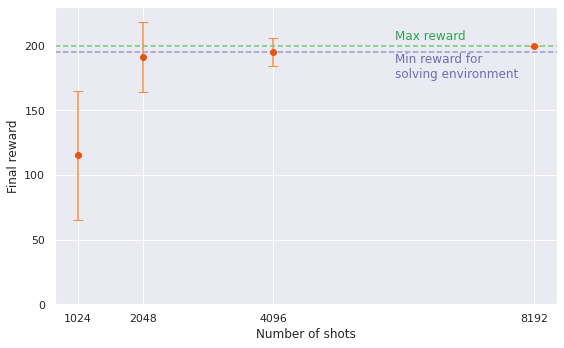

In [19]:
num_shots = [1024, 2048, 4096, 8192]
mean_reward = [115.1, 191, 195, 199.7]
std_reward = [49.9, 27.2, 10.9, 0.3]

import seaborn as sns
sns.set_theme()

cmap = plt.get_cmap('tab20c')

fig = plt.figure(figsize=(8,5))
plt.axhline([200], ls = 'dashed', c=cmap(9))
plt.text(6000,205, s='Max reward', c=cmap(8))

plt.axhline([195], ls = 'dashed', c=cmap(13))
plt.text(6000,175, s='Min reward for\nsolving environment', c=cmap(12))

plt.errorbar(num_shots, mean_reward, yerr=std_reward, fmt='o', c = cmap(4), capsize=5, ecolor = cmap(5))
plt.ylim([0,230])
plt.xticks([1024, 2048, 4096, 8192])
plt.xlabel("Number of shots")
plt.ylabel("Final reward")

plt.tight_layout()
plt.show()